In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from PIL import Image
from tqdm import trange
import gymnasium as gym
import numpy as np
from sapien.core import Pose
import matplotlib.pyplot as plt
import os
import warnings
import shutil
import random
from plot_utils import *
from itertools import product, combinations, permutations

from utils import *
from agent_env_utils import *
from scene_helpers import get_position_range, create_config, create_directories, finalize_quadrant
from config import potential_sizes,direction_length,scales,moving_directions,color_maps,background_quadrants,background_specs

In [2]:
#generate complex trajectory
moving_directions = [
    "left",
    "right",
    "front",
    "behind",
    "left_front",
    "left_behind",
    "right_front",
    "right_behind",
    "circle_lc",
    "circle_lcc",
    "behind_left",
    "front_left"
]

# Define more complex directions
complex_directions = [
    "circle_lc", "circle_lcc", "left_front", "left_behind", 
    "right_front", "right_behind", "behind_left", "front_left"
]

# Give preference to complex directions by repeating them in the list (weighted sampling)
weighted_moving_directions = moving_directions + complex_directions * 3  # Increase occurrence of complex directions
# Generate paths from 5 directions
trajectories = []

# Sampling with weighted preference
for i in range(5, 6):  # adjust the complexity(number of different direction in the trajectory)
    for _ in range(20):  # Generate 20 samples each
        selected_directions = random.sample(weighted_moving_directions, i)
        trajectories.append(tuple(selected_directions))


In [3]:
# Define directories
data_dir = "../benchmark/motion/motion_trajectory"
final_dir = create_directories(data_dir, empty=True)

color_keys = list(color_maps.keys())
color_samples = list(itertools.permutations(color_keys , 1))
random.seed(42)
random.shuffle(color_samples)
object_types = ['cube', 'sphere', 'custom']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")
    idx = 0
    outputs = []
    for background in trange(4):
        for quadrant_idx, quadrant in enumerate(background_quadrants[background]):
            # Decide the boundary of each background
            object_position_range= get_position_range(background_quadrants, background, scale=0.6)
            ranges = [tuple(range) for range in object_position_range]
            for size_idx, size in enumerate(potential_sizes):
                for obj_type in object_types:
                    color_pairs = ["predefinedColor" if obj_type == 'custom' else color_samples][0]
                for color_idx in range(len(color_pairs)):
                    color_1 = color_pairs[color_idx][0]                                      
                    if(obj_type == 'custom'):
                        obj_config = {'obj_type': obj_type, 'name': "002_master_chef_can", 'size': size*1.1/2, 'ranges': ranges, 'static': True}
                    else:
                        obj_config = {'size': size, 'color': color_maps[color_1], 'obj_type': obj_type, 'ranges': ranges, 'static': True}     
                        
                    configs = [obj_config]
                
                    configs_collate = collate_infos(configs)
                    env.register_configures(configs_collate)
                    _ = env.reset(options={"reconfigure": True})

                    env.initialize_objects(background=background)
                    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))

                    initilization_poses = env.get_important_obj_poses(mode="all")
                    for scale_idx, scale in enumerate(scales):
                        for k,trajectory in enumerate(trajectories):
                            ###Intializing for each direction given the same intialized positions above
                            env.set_poses(initilization_poses)

                            direction_configs = [(0, 0, direction) for direction in trajectory]
                            distances = [direction_length for _ in trajectory]
                            frames = env.move_in_directions(direction_configs, distances, steps=8, scale=scale, camera_view="all", background=background)

                            image_dir = os.path.join(final_dir, f"episode{idx}_traj{k}_{len(trajectory)}directions_scale{scale}")

                            save_images_pararell(frames['top0'], image_dir)
                            video_name = os.path.join(image_dir, f"episode_{idx}_traj_{k}_{len(trajectory)}_directions_scale_{scale}.mp4")  # Using idx for video naming
                            generate_video(video_name, frames['top0'], fps=10, color_change=True)
                            
                            output = {
                                "episode": idx,
                                "trajectory": trajectory,
                                "complexity": len(trajectory),
                                "source": image_dir,
                                "size": size,
                                "scale": scale,
                                "background": background,
                                "quadrant": quadrant,
                                }
                            outputs.append(output)
                            idx += 1
                    
    write_out(f"{data_dir}/index.jsonl", outputs)
    
                
del env


[2024-10-15 06:06:00.378] [svulkan2] [error] GLFW error: X11: The DISPLAY environment variable is missing
[2024-10-15 06:06:00.378] [svulkan2] [warning] Continue without GLFW.
  0%|          | 0/4 [00:00<?, ?it/s]OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFM

KeyboardInterrupt: 

In [6]:
write_out(f"{data_dir}/index.jsonl", outputs)

plot

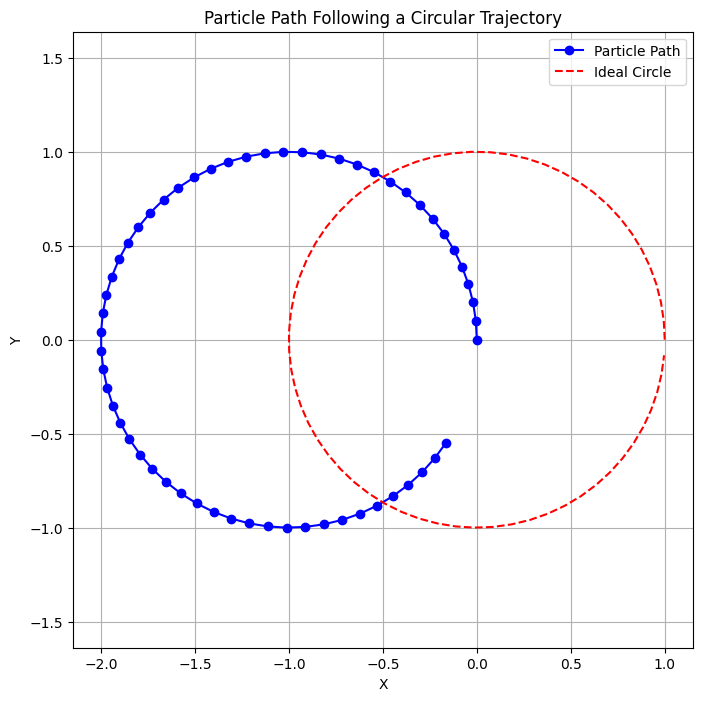

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = 1
delta_t = 0.1

t_values = np.arange(0, 2*np.pi, delta_t)

# Positions
x_values = r * np.cos(t_values)
y_values = r * np.sin(t_values)

# Displacements
displacements = []
for i in range(len(t_values) - 1):
    delta_x = x_values[i + 1] - x_values[i]
    delta_y = y_values[i + 1] - y_values[i]
    displacements.append((delta_x, delta_y))

# Initial position
x, y = 0, 0

# Path of the particle
path_x = [x]
path_y = [y]

for dx, dy in displacements[:-5]:
    x += dx
    y += dy
    path_x.append(x)
    path_y.append(y)

# Plot the path
plt.figure(figsize=(8, 8))
plt.plot(path_x, path_y, 'bo-', label='Particle Path')
plt.plot(x_values, y_values, 'r--', label='Ideal Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Path Following a Circular Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()